# Mount cloud drive to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Check GPU




In [ ]:
!nvidia-smi

Thu Jun 17 04:37:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# clone DB code form [github](https://github.com/MhLiao/DB)

In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
import os 
if os.path.exists("DB"):
  print("DB code file had been cloned")
else:
  !git clone https://github.com/MhLiao/DB.git
%cd DB
!ls

DB code file had been cloned
/content/drive/MyDrive/DB
assets	   datasets	 eval.py	outputs		 results     train.py
backbones  decoders	 experiment.py	__pycache__	 structure   workspace
concern    demo.py	 experiments	README.md	 trainer.py
data	   demo_results  model		requirement.txt  training


# Getting Started
* install third-party libraries
* web for install [pytorch](https://pytorch.org/get-started/previous-versions/)

In [ ]:
%cd /content/drive/MyDrive/DB
!pip install -r requirement.txt
!pip install torch
!pip install torchvision

/content/drive/MyDrive/DB
     |████████████████████████████████| 122kB 7.5MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
     |████████████████████████████████| 133kB 46.8MB/s 
     |████████████████████████████████| 5.6MB 49.0MB/s 
     |████████████████████████████████| 686kB 43.4MB/s 
     |████████████████████████████████| 256kB 52.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


  * Check if cuda is available()

In [ ]:
import torch
torch.cuda.is_available()

True

* Build deformable convolution operator

    1.  set environment variable CUDA_HOME= path to cuda file
    2.   if the version of pytorch higher than 1.3, you need **replace "AT_CHECK" with "TORCH_CHECK"** in DB/assets/ops/dcn/src/deform_conv_cuda.cpp and DB/assets/ops/dcn/src/deform_pool_cuda.cpp.
    3. run “python setup.py build_ext --inplace”

* you need to delete the build directory before you re-build it.





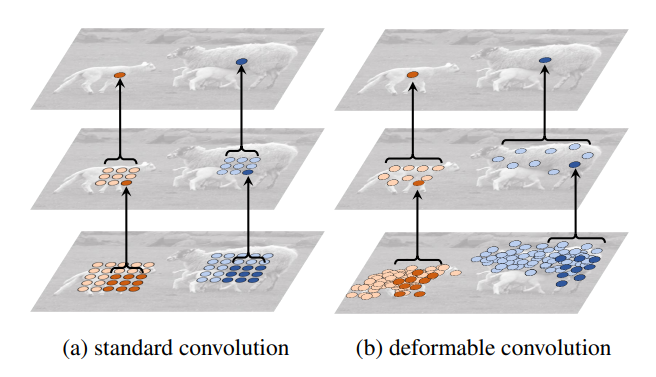

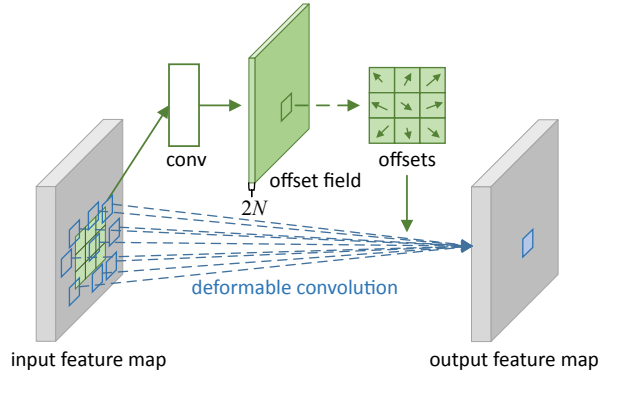

In [ ]:
!ls /usr/local/
!export CUDA_HOME="/usr/local/cuda-10.1"

bin	   cuda-10.1  games		  lib	       man	  share
cuda	   cuda-11.0  _gcs_config_ops.so  LICENSE.txt  sbin	  src
cuda-10.0  etc	      include		  licensing    setup.cfg  xgboost


In [ ]:
%cd /content/drive/MyDrive/DB/assets/ops/dcn
!rm -r build
!python setup.py build_ext --inplace

/content/drive/MyDrive/DB/assets/ops/dcn
running build_ext
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:369: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
building 'deform_conv_cuda' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/src
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/torch/include -I/usr/local/lib/python3.7/dist-packages/torch/include/torch/csrc/api/include -I/usr/local/lib/python3

# Demo 
* Use pretrained model provided from github
* It will take about 8 mins for the first time

In [ ]:
%cd /content/drive/MyDrive/DB/
!CUDA_VISIBLE_DEVICES=0 python demo.py experiments/seg_detector/ic15_resnet50_deform_thre.yaml \
--image_path datasets/icdar2015/test_images/img_108.jpg --resume model/ic15_resnet50 --box_thresh 0.5 --visualize

/content/drive/MyDrive/DB
verbose: True
Initializing log dir for workspace/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100% 97.8M/97.8M [00:00<00:00, 224MB/s]
Resuming from model/ic15_resnet50
Resumed from model/ic15_resnet50


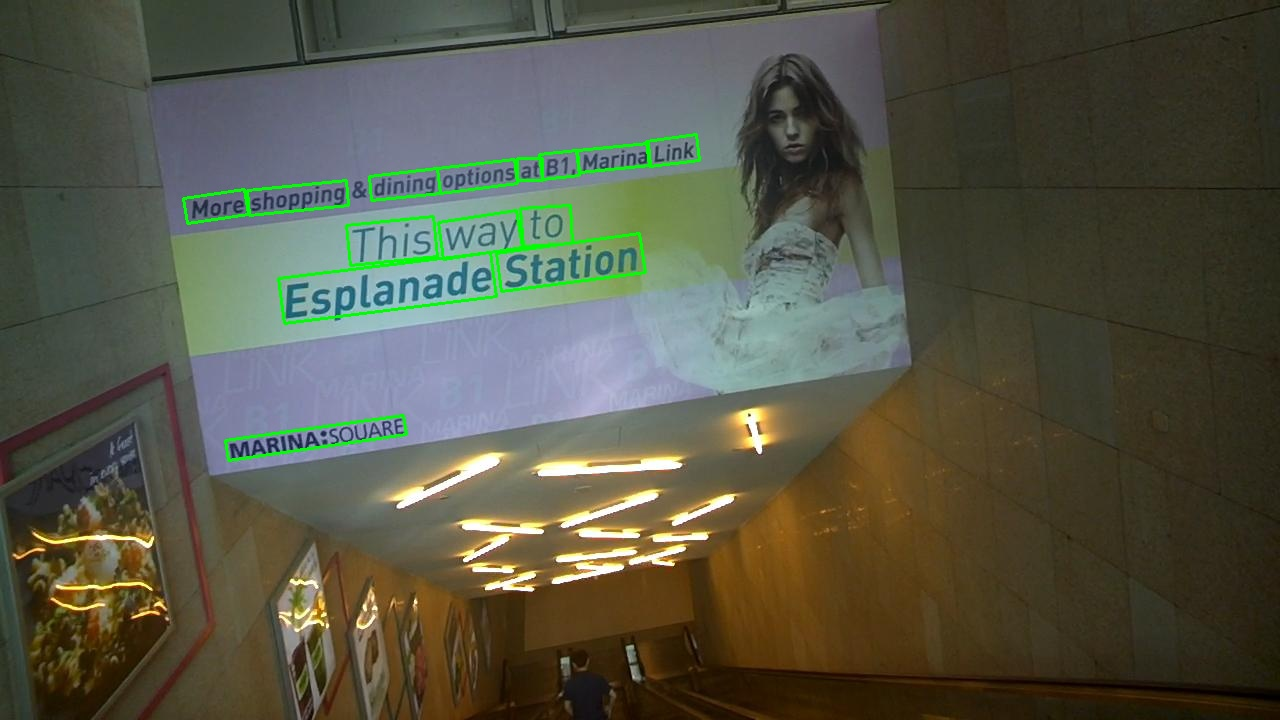

In [ ]:
from IPython.display import Image, display
display(Image('demo_results/img_108.jpg',width=640, height=640))

# Train on AICUP released dataset


## Prepare dataset
- transform json form to text form
- set up the path of dataset
  - datasets/AICUP1/train_images
  - datasets/AICUP1/train_gts
  - datasets/AICUP1/train_list.txt

In [ ]:
#@title code file for transform json form to text form
'''
import os
import json
import argparse
from PIL import Image

def read_jsonFile(input_json_dir,fname):
	info_list = []
	path = os.path.join(input_json_dir,fname)
	with open(path, 'r',encoding="utf-8") as f:
		json_i = json.load(f)
	shapes = json_i['shapes']
	for i in range(len(shapes)):
		temp = {}
		temp['group_id']=shapes[i]['group_id']
		temp['points']=shapes[i]['points']
		temp['label']=shapes[i]['label']
		info_list.append(temp)

	return info_list

def getBboxInfo(i_list):
	# 0:中文字串 1:中文單字 2:英數字串 3:中英數字串 4:中文單字字串 5:其他 255:don't care
	allBbox = []
	for info in i_list:
		x1,y1 = round(info['points'][0][0]),round(info['points'][0][1])
		x2,y2 = round(info['points'][1][0]),round(info['points'][1][1])
		x3,y3 = round(info['points'][2][0]),round(info['points'][2][1])
		x4,y4 = round(info['points'][3][0]),round(info['points'][3][1])
		allBbox.append((x1,y1,x2,y2,x3,y3,x4,y4,info['label'],info['group_id']))
		
	return allBbox

def writeToFile(output_path,file_name, result):
	path = os.path.join(output_path,file_name)
	with open(path, "w", encoding="utf-8") as writeFile:  
		for box in result:
			string = ",".join(str(p) for p in box)+"\n"
			writeFile.write(string)
		writeFile.close()
if __name__ == '__main__':
	parser = argparse.ArgumentParser()
	parser.add_argument('--input_json_dir',type=str,default="./datasets/AICUP1/train_jsons",help='path of GT json directory')
	parser.add_argument('--output_txt_dir',type=str,default="./datasets/AICUP1/train_gts",help='path of GT txt directory')
	parser.add_argument('--image_list',type=str,default="./datasets/AICUP1_train/train_list.txt",help='path of image list')
	arg = parser.parse_args()

	json_list = os.listdir(arg.input_json_dir)

	#create output directory
	if not os.path.exists(arg.output_txt_dir):
		os.mkdir(arg.output_txt_dir)
		
	for json_file in sorted(json_list):
		outputFileName = json_file.replace('json', 'jpg')+'.txt'
		info_list = read_jsonFile(arg.input_json_dir,json_file)
		bboxlist = getBboxInfo(info_list)
		writeToFile(arg.output_txt_dir,outputFileName, bboxlist)

		#create image list txt file
		with open(arg.image_list,'a',encoding="utf-8") as f:
			f.write(json_file.replace('json', 'jpg')+'\n')
'''  


'\nimport os\nimport json\nimport argparse\nfrom PIL import Image\n\ndef read_jsonFile(input_json_dir,fname):\n\tinfo_list = []\n\tpath = os.path.join(input_json_dir,fname)\n\twith open(path, \'r\',encoding="utf-8") as f:\n\t\tjson_i = json.load(f)\n\tshapes = json_i[\'shapes\']\n\tfor i in range(len(shapes)):\n\t\ttemp = {}\n\t\ttemp[\'group_id\']=shapes[i][\'group_id\']\n\t\ttemp[\'points\']=shapes[i][\'points\']\n\t\ttemp[\'label\']=shapes[i][\'label\']\n\t\tinfo_list.append(temp)\n\n\treturn info_list\n\ndef getBboxInfo(i_list):\n\t# 0:中文字串 1:中文單字 2:英數字串 3:中英數字串 4:中文單字字串 5:其他 255:don\'t care\n\tallBbox = []\n\tfor info in i_list:\n\t\tx1,y1 = round(info[\'points\'][0][0]),round(info[\'points\'][0][1])\n\t\tx2,y2 = round(info[\'points\'][1][0]),round(info[\'points\'][1][1])\n\t\tx3,y3 = round(info[\'points\'][2][0]),round(info[\'points\'][2][1])\n\t\tx4,y4 = round(info[\'points\'][3][0]),round(info[\'points\'][3][1])\n\t\tallBbox.append((x1,y1,x2,y2,x3,y3,x4,y4,info[\'label\'],info[

## Set Config file
- path = experiments/seg_detector/*.yaml
- Refer to icdar15 Config file provided on DB github 
  - base_*.yml for dataset setting
  - *_resnet_deform_thre.yaml for model and triaing setting

## Start Training
- For workshop, we just use 50 images which it totally not enough.Apparently, the result will be bad.
- It will take about 10 mins for 5 epochs
- Training output model will be saved at outputs/workspace/DB/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss/model/final

In [ ]:
!CUDA_VISIBLE_DEVICES=0 python train.py experiments/seg_detector/AICUP_resnet50_deform_thre.yaml \
--num_gpus 1 --epochs 60 --num_workers 8 --batch_size 4 \
--resume outputs/workspace/DB/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss/model/final_60 --start_epoch 5

[INFO] [2021-06-15 14:36:53,592] Resuming from outputs/workspace/DB/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss/model/final_60
[INFO] [2021-06-15 14:36:55,126] Resumed from outputs/workspace/DB/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss/model/final_60
[INFO] [2021-06-15 14:36:55,129] Training epoch 5
[INFO] [2021-06-15 14:37:08,308] step:      0, epoch:   5, loss: 3.961763, lr: 0.006974
[INFO] [2021-06-15 14:37:08,313] bce_loss: 0.499488
[INFO] [2021-06-15 14:37:08,314] thresh_loss: 0.520670
[INFO] [2021-06-15 14:37:08,315] l1_loss: 0.094366
[INFO] [2021-06-15 14:49:39,538] step:    450, epoch:   5, loss: 2.042527, lr: 0.006974
[INFO] [2021-06-15 14:49:39,540] bce_loss: 0.250736
[INFO] [2021-06-15 14:49:39,541] thresh_loss: 0.213636
[INFO] [2021-06-15 14:49:39,542] l1_loss: 0.057521
[INFO] [2021-06-15 15:02:10,666] step:    900, epoch:   5, loss: 2.076771, lr: 0.006974
[INFO] [2021-06-15 15:02:10,675] bce_loss: 0.259791
[INFO] [2021-06-15 15

In [ ]:
%cd /content/drive/MyDrive/DB
!CUDA_VISIBLE_DEVICES=0 python train.py experiments/seg_detector/AICUP_resnet50_deform_thre.yaml \
--num_gpus 1 --epochs 60 --num_workers 4 --batch_size 8

/content/drive/MyDrive/DB
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100% 97.8M/97.8M [00:00<00:00, 132MB/s]
[INFO] [2021-06-15 14:23:42,025] Training epoch 0
[INFO] [2021-06-15 14:24:05,824] step:      0, epoch:   0, loss: 42.691994, lr: 0.007000
[INFO] [2021-06-15 14:24:05,828] bce_loss: 7.597361
[INFO] [2021-06-15 14:24:05,831] thresh_loss: 0.922746
[INFO] [2021-06-15 14:24:05,832] l1_loss: 0.378244
Traceback (most recent call last):
  File "train.py", line 70, in <module>
    main()
  File "train.py", line 67, in main
    trainer.train()
  File "/content/drive/MyDrive/DB/trainer.py", line 86, in train
    epoch=epoch, step=self.steps)
  File "/content/drive/MyDrive/DB/trainer.py", line 109, in train_step
    results = model.forward(batch, training=True)
  File "/content/drive/MyDrive/DB/structure/model.py", line 62, in forward
    batch[key] = value.to(self.device)
KeyboardInterrupt


## Evaluation
-  Usually, to reach the normal accuracy, training total loss should be around 0.5 or even lower. As you can see, above training loss is way too far from the 0.5. Therefore, we use trained model for workshop demo.
- This evaluated method is provided by DB github to evaluated the model workes will or not. It is not the one we use in AICUP contest.




In [ ]:
!CUDA_VISIBLE_DEVICES=0 python eval.py experiments/seg_detector/AICUP_resnet50_deform_thre.yaml --resume model/AICUP_WORKSHOP --box_thresh 0.5

[INFO] [2021-05-07 06:51:24,495] Resuming from model/AICUP_WORKSHOP
[INFO] [2021-05-07 06:51:34,759] Resumed from model/AICUP_WORKSHOP
100% 10/10 [00:04<00:00,  2.17it/s]
[INFO] [2021-05-07 06:51:39,580] precision : 0.388889 (10)
[INFO] [2021-05-07 06:51:39,581] recall : 0.250000 (10)
[INFO] [2021-05-07 06:51:39,581] fmeasure : 0.304348 (1)


## Demo
- Like Evaluation,we use trained model.

In [ ]:
%cd /content/drive/MyDrive/DB/
!CUDA_VISIBLE_DEVICES=0 python demo.py experiments/seg_detector/AICUP_resnet50_deform_thre.yaml \
--resume /content/drive/MyDrive/DB/outputs/workspace/DB/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss/model/model_epoch_79_minibatch_0 \
--image_path /datasets/AICUP_1/test_images/img_55.jpg \
--box_thresh 0.5 --visualize

/content/drive/MyDrive/DB
verbose: True
Initializing log dir for workspace/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss
1
/content/drive/MyDrive/datasets/AICUP_1/test_images/img_1.jpg
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100% 97.8M/97.8M [00:01<00:00, 101MB/s] 
Resuming from /content/drive/MyDrive/DB/outputs/workspace/DB/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss/model/model_epoch_79_minibatch_0
Resumed from /content/drive/MyDrive/DB/outputs/workspace/DB/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss/model/model_epoch_79_minibatch_0
2
/content/drive/MyDrive/datasets/AICUP_1/test_images/img_2.jpg
Resuming from /content/drive/MyDrive/DB/outputs/workspace/DB/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss/model/model_epoch_79_minibatch_0
Resumed from /content/drive/MyDrive/DB/outputs/workspace/DB/SegDetectorModel-s

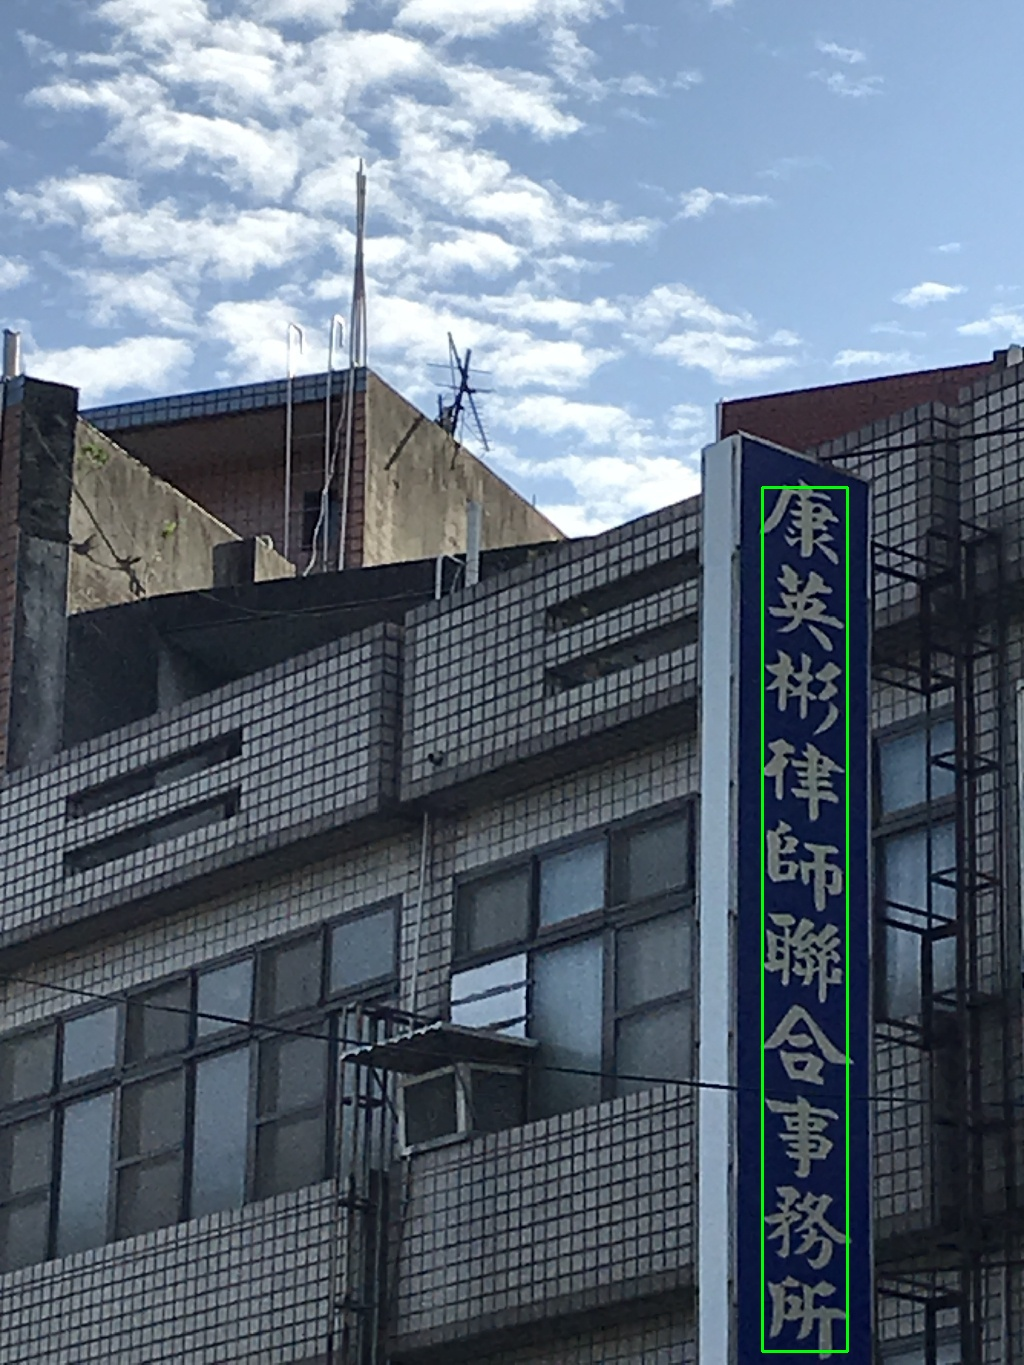

In [ ]:
from IPython.display import Image, display
display(Image('/content/drive/MyDrive/DB/demo_results/img_55.jpg',width=500, height=500))

# How to improve?
- run more epoch
- Using more training data
- do more data augmentation
- Adjust parameter in config file
- Using other network( method )